In [2]:
import getpass, queue, random, sys, time, tqdm
import numpy as np
import torch
from torchvision.transforms import *

sys.path.append('../..')
from DL.utils import *
from DL.networks import *
from DL.sqlite_data_loader import SQLDataLoader
from Database.DB_models import *

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
EMBEDDING_MODEL = '/home/lynx/pretrainedmodels/embedding_triplet_resnet50_1499/triplet_resnet50_1499.tar'
CROP_DIR = '/datadrive/missouricameratraps/crops_detector/'
DB_LIMIT = 5000

In [4]:
DB_NAME = getpass.getpass('Enter database name:')
DB_USER = getpass.getpass('Enter username for database:')
DB_PASSWORD = getpass.getpass('Enter password for database user:')

Enter database name:········
Enter username for database:········
Enter password for database user:········


In [5]:
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
sample_ids = [s[0] for s in dataset.samples]

Reading database to get samples.
[0, 4964, 10, 26, 36]
Load dataset mean and std from database


In [6]:
checkpoint = load_checkpoint(EMBEDDING_MODEL)
if checkpoint['loss_type'].lower() == 'center' or checkpoint['loss_type'].lower() == 'softmax':
    embedding_net = SoftmaxNet(checkpoint['arch'], checkpoint['feat_dim'], False)
else:
    embedding_net = NormalizedEmbeddingNet(checkpoint['arch'], checkpoint['feat_dim'], False)
model = torch.nn.DataParallel(embedding_net).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()


DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [7]:
model_inner_resnet = list(model.children())[0].inner_model
# model_inner_resnet.eval() # not sure if this is necessary

In [85]:
# Create a hook function to store layer outputs
layer_outputs = []
def hook_function(module, input, output):
    layer_outputs.append(output)

# Register the hook
hook_handle = model_inner_resnet.layer4[0].conv1.register_forward_hook(hook_function)
# hook_handle = model_inner_resnet.conv1.register_forward_hook(hook_function)

# Get output of specified layer for all input samples
dataset.image_mode()
with torch.no_grad():
    for sid in tqdm.tqdm(sample_ids):
        img = dataset.loader(sid)
        img_tensor = dataset.eval_transform(img)
        output = model.forward(img_tensor.unsqueeze(0))

# Deregister the hook
hook_handle.remove()

100%|██████████| 5000/5000 [01:35<00:00, 52.24it/s]


In [86]:
print(layer_outputs[0].shape)
print(len(layer_outputs))
print(len(sample_ids))

torch.Size([1, 512, 14, 14])
5000
5000


torch.Size([3, 224, 224])


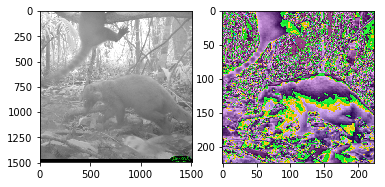

In [140]:
random_sid = random.sample(sample_ids, 1)[0]
random_sid_idx = sample_ids.index(random_sid)
# Visualize the random sample image to use as query image
dataset.image_mode()
random_img = dataset.loader(random_sid)
random_img_tensor = dataset.eval_transform(random_img)
print(random_img_tensor.shape)
plt.subplot(1,2,1)
plt.imshow(np.asarray(random_img))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ToPILImage()(random_img_tensor)))

In [141]:
intermediate_output = layer_outputs[random_sid_idx].cpu().detach().numpy()
print(intermediate_output.shape)

(1, 512, 14, 14)


In [142]:
#possibly interesting filters: (52, 399), 744

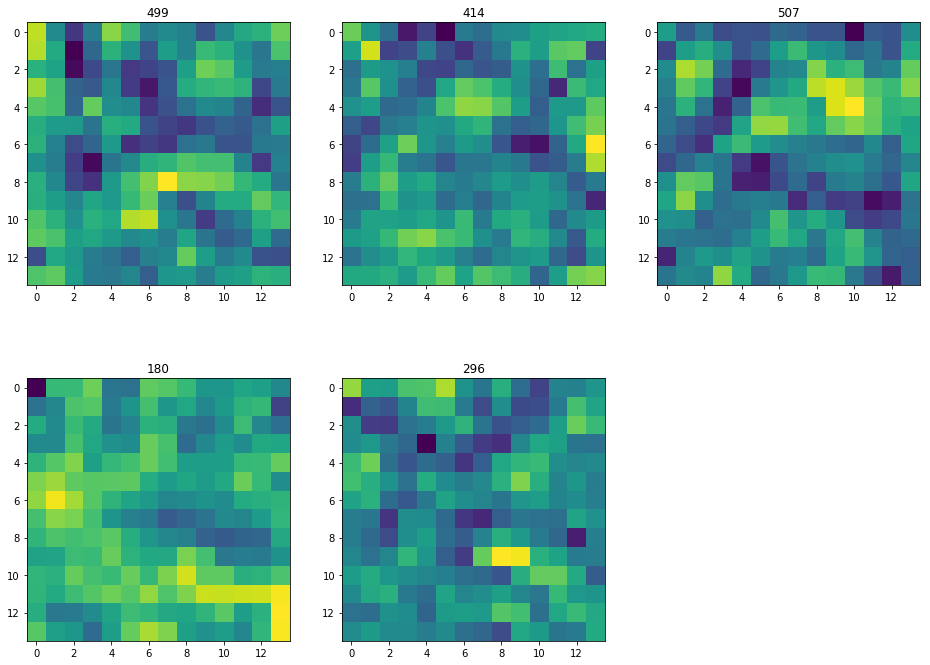

In [143]:
channels_to_vis = random.sample(range(intermediate_output.shape[1]), 5)
n_channels_to_vis = len(channels_to_vis)
plt.figure(figsize=(16,12))
for i in range(n_channels_to_vis):
    plt.subplot(2,3,i+1)
    channel_no = channels_to_vis[i]
    plt.imshow(intermediate_output[0,channel_no,:,:], cmap='viridis')
    plt.title(str(channel_no))
#     plt.axis('off')

In [144]:
pos = (9,4)
pad = 6
activation_vector_at_pos = intermediate_output[0, :, pos[0], pos[1]]


In [145]:
print(activation_vector_at_pos.shape)

(512,)


In [146]:
class PQItem:
    def __init__(self, euc_dist, idx, act_vec):
        self.euc_dist = euc_dist
        self.idx = idx
        self.act_vec = act_vec
    
    def __lt__(self, other):
        return self.euc_dist < other.euc_dist

In [147]:
pq = queue.PriorityQueue()

for imidx in tqdm.tqdm(range(len(sample_ids))):
    if imidx == random_sid_idx:
        continue
    int_output = layer_outputs[imidx].cpu().detach().numpy()
    # Iterate over positions in padding region
    ymin = max(pos[0] - pad, 0)
    ymax = min(pos[0] + pad, intermediate_output.shape[2]-1)
    xmin = max(pos[1] - pad, 0)
    xmax = min(pos[1] + pad, intermediate_output.shape[3]-1)
    for y in range(ymin, ymax+1):
        for x in range(xmin, xmax+1):
            im_act_vect_at_pos = int_output[0, :, y, x]
            edist = np.linalg.norm(im_act_vect_at_pos - activation_vector_at_pos)
            pqitem = PQItem(edist, imidx, im_act_vect_at_pos)
            pq.put(pqitem)


100%|██████████| 5000/5000 [00:11<00:00, 430.02it/s]


In [148]:
k = 10
closest_k_idx = []
closest_k_edist = []
while len(closest_k_idx) < k:
    next_pqitem = pq.get()
    closest_k_idx.append(next_pqitem.idx)
    closest_k_edist.append(next_pqitem.euc_dist)
print(closest_k_idx)
print(closest_k_edist)

[891, 891, 891, 891, 891, 1897, 1625, 583, 1491, 4691]
[8.31586, 11.323346, 11.34734, 11.515422, 11.518769, 11.603807, 12.012483, 12.086402, 12.193446, 12.516509]


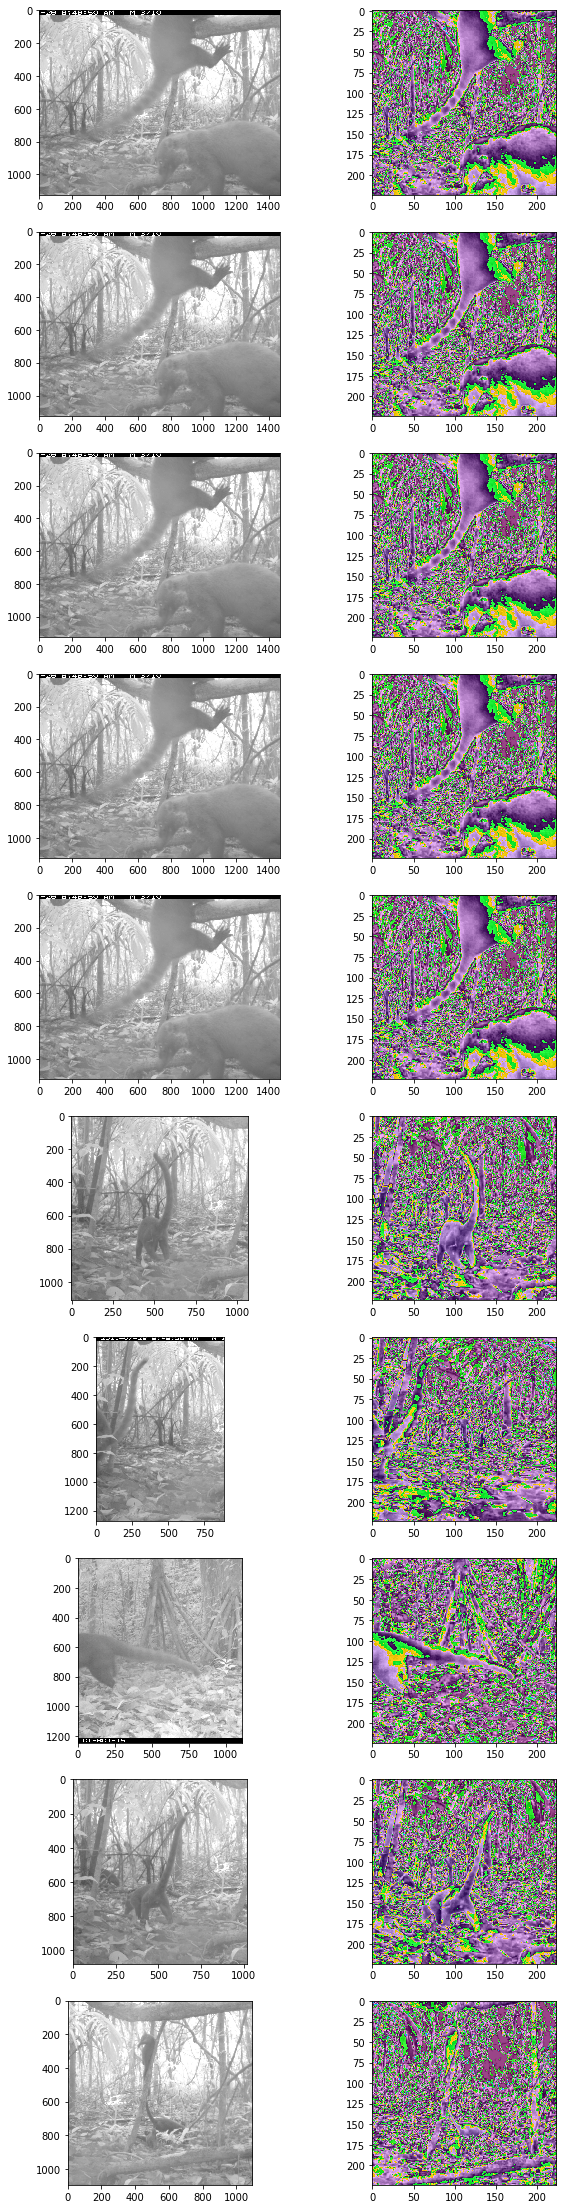

In [149]:
plt.figure(figsize=(10, 40))
for i in range(k):
    min_edist_sid = sample_ids[closest_k_idx[i]]
    # Visualize the image
    dataset.image_mode()
    min_edist_img = dataset.loader(min_edist_sid)
    min_edist_img_tensor = dataset.eval_transform(min_edist_img)
    plt.subplot(k,2,i*2 + 1)
    plt.imshow(np.asarray(min_edist_img))
    plt.subplot(k,2,i*2 + 2)
    plt.imshow(np.asarray(ToPILImage()(min_edist_img_tensor)))

torch.Size([3, 224, 224])


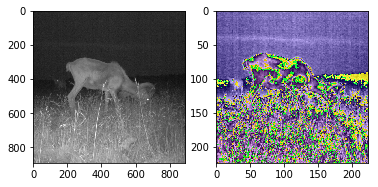

In [46]:
min_edist_sid = sample_ids[min_edist_idx]
# Visualize the image
dataset.image_mode()
min_edist_img = dataset.loader(min_edist_sid)
min_edist_img_tensor = dataset.eval_transform(min_edist_img)
print(min_edist_img_tensor.shape)
plt.subplot(1,2,1)
plt.imshow(np.asarray(min_edist_img))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ToPILImage()(min_edist_img_tensor)))

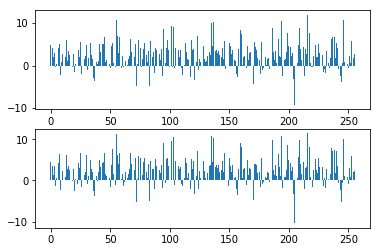

In [35]:
plt.subplot(2,1,1)
plt.bar(range(len(activation_vector_at_pos)), activation_vector_at_pos)
plt.subplot(2,1,2)
plt.bar(range(len(im_act_vect_at_pos)), im_act_vect_at_pos)
plt.show()

In [139]:
print(random_sid_idx)

4509


In [ ]:
# Cool sample IDs: 4509